In [ ]:
# Importemos las librerias
import pandas as pd
import matplotlib.pyplot as plt
import os
from pandas import DataFrame
import numpy as np
import cv2
import shutil
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from joblib import Parallel, delayed


# Análisis del dataset


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/CE/Introduccion a patrones/Proyecto_2/DataSetPatrones/metadata.csv')


print("Dimensiones de las imagenes: 299 x 299")

# Contar el número de imágenes en cada clase de etiqueta y mostrar los resultados
print(dataset['label'].value_counts())

# Volarnos varias imagenes de la carpeta normal

# Hay que hacer todo el feature engineering, al dataset para luego hacer el feature extractor y aplicar el modelo
# Recordemos que el modelo se entrena con los cuatro set de imagenes y en la ultima capa genera cuatro neuronas.


Dimensiones de las imagenes: 299 x 299
Normal             10192
Lung_Opacity        6012
COVID               3616
Viral Pneumonia     1345
Name: label, dtype: int64


In [ ]:
##################################### Vamos a reducir la cantidad de imagenes #####################################

#normal_data = df[df["labels"] == "normal"]
#reduced_normal_data = normal_data.sample(n=5096, random_state=1)
#reduced_data = pd.concat([df[df["labels"] != "normal"], reduced_normal_data])
#reduced_data.to_csv("/content/drive/MyDrive/CE/Introduccion a patrones/Proyecto_2/DataSetPatrones/New_metadata.csv", index=False)

newDataset = pd.read_csv('/content/drive/MyDrive/CE/Introduccion a patrones/Proyecto_2/DataSetPatrones/New_metadata.csv')

# Contar el número de imágenes en cada clase de etiqueta y mostrar los resultados
print(newDataset['labels'].value_counts())

lung_opacity    6012
normal          5096
covid           3616
pneumonia       1345
Name: labels, dtype: int64


In [ ]:
##################################### Creamos un nuevo csv con las rutas de las imagenes y sus lables #####################################

# Definir los directorios que contienen los diferentes tipos de imágenes
dirlist = [
    '/content/drive/MyDrive/CE/Introduccion a patrones/Proyecto_2/DataSetPatrones/COVID',
    '/content/drive/MyDrive/CE/Introduccion a patrones/Proyecto_2/DataSetPatrones/Lung_Opacity',
    '/content/drive/MyDrive/CE/Introduccion a patrones/Proyecto_2/DataSetPatrones/Normal',
    '/content/drive/MyDrive/CE/Introduccion a patrones/Proyecto_2/DataSetPatrones/Pneumonia'
]

# Crear un diccionario que mapea las etiquetas a los índices
label_map = {
    'covid': 0,
    'lung_opacity': 1,
    'normal': 2,
    'pneumonia': 3
}

# Crear dos listas vacías para almacenar los paths de archivo y las etiquetas
filepaths = []
labels = []

# Iterar a través de los directorios y agregar los paths de archivo y las etiquetas a las listas creadas anteriormente
for idx, d in enumerate(dirlist):
    flist = os.listdir(d)
    for f in flist:
        fpath = os.path.join(d, f)
        filepaths.append(fpath)
        labels.append(list(label_map.keys())[idx])

# Crear un dataframe con los paths de archivo y las etiquetas
df = pd.DataFrame({'file_paths': filepaths, 'labels': labels})

# Reorganizar el dataframe a un formato legible y guardarlo en un archivo CSV
df.to_csv('/content/drive/MyDrive/CE/Introduccion a patrones/Proyecto_2/DataSetPatrones/New_metadata.csv', index=False)


# Mostrar las primeras filas del dataframe
df.head()


normal          10192
lung_opacity     6012
covid            3616
pneumonia        1345
Name: labels, dtype: int64


,file_paths,labels
0,/content/drive/MyDrive/CE/Introduccion a patro...,covid
1,/content/drive/MyDrive/CE/Introduccion a patro...,covid
2,/content/drive/MyDrive/CE/Introduccion a patro...,covid
3,/content/drive/MyDrive/CE/Introduccion a patro...,covid
4,/content/drive/MyDrive/CE/Introduccion a patro...,covid


In [ ]:

##################################### Validar si hay imagenes corruptas #####################################

df = pd.read_csv('/content/drive/MyDrive/CE/Introduccion a patrones/Proyecto_2/DataSetPatrones/New_metadata.csv')

for index, row in df.iterrows():
    file_path = row['file_paths'] # Suponiendo que la columna que contiene la ruta se llama "ruta"
    try:
        img = Image.open(file_path)
        img.verify()
        print(f"{file_path}: La imagen está bien formada.")
    except (IOError, SyntaxError) as e:
        print(f"{file_path}: La imagen está corrupta o no se puede cargar.")
        #os.remove(file_path)  # Si la imagen está corrupta, se puede eliminar para evitar que afecte el modelo


In [ ]:
##################################### Reducir las dimesiones a 244 x 244 #####################################

# Selecciona las filas con la etiqueta "pneumonia"
datos_pneumonia = newDataset[newDataset["labels"] == "covid"]

# Itera a través de las filas y redimensiona las imágenes
for i, fila in datos_pneumonia.iterrows():
    # Carga la imagen utilizando la ruta de archivo en la columna "file_paths"
    imagen = Image.open(fila["file_paths"])
    
    # Redimensiona la imagen a 244x244 píxeles
    nueva_imagen = imagen.resize((244, 244))
    
    # Guarda la nueva imagen utilizando un nombre de archivo único
    nueva_imagen.save(f'/content/drive/MyDrive/CE/Introduccion a patrones/Proyecto_2/DataSetPatrones/COVID_FE/Covid-{i}.png')



In [ ]:
##################################### Cambiar el nombre de las imagenes al correcto #####################################

# Define la ruta de la carpeta donde se encuentran las imágenes
ruta_carpeta = '/content/drive/MyDrive/CE/Introduccion a patrones/Proyecto_2/DataSetPatrones/Lung_Opacity_FExtractor'

# Contador para los nombres de las imágenes
contador = 1
#Lung_Opacity-6012
# Recorre todas las imágenes en la carpeta
for archivo in os.listdir(ruta_carpeta):
    if archivo.endswith(".jpg") or archivo.endswith(".png"): # puedes agregar o modificar las extensiones que necesites
        # Crea el nuevo nombre de la imagen
        nuevo_nombre = "Lung_Opacity-" + str(contador) + ".png" # puedes cambiar .jpg por la extension que manejen las imagenes

        # Renombra el archivo
        os.rename(os.path.join(ruta_carpeta, archivo), os.path.join(ruta_carpeta, nuevo_nombre))

        # Incrementa el contador
        contador += 1


In [ ]:

##################################### Vamos a normalizadar los pixeles de todas las imagenes #####################################

# Lee el archivo CSV
newDataset = pd.read_csv('/content/drive/MyDrive/CE/Introduccion a patrones/Proyecto_2/DataSetPatrones/MetadataNormalizada.csv')

# Itera sobre cada fila del archivo CSV
for index, row in newDataset.iterrows():
    # Lee la ruta de la imagen de la fila actual
    imagen_ruta = row["file_paths"]

    # Carga la imagen en escala de grises
    imagen = cv2.imread(imagen_ruta, cv2.IMREAD_GRAYSCALE)

    # Convierte la imagen en un array NumPy de punto flotante
    imagen_flotante = imagen.astype("float32")

    # Calcula la media y la desviación estándar de los valores de píxeles en la imagen
    media, desviacion = cv2.meanStdDev(imagen_flotante)

    # Establece la media y la desviación estándar para estandarizar los valores de los píxeles
    media_estandarizada = 127
    desviacion_estandarizada = 63

    # Aplica la estandarización a los valores de los píxeles de la imagen
    imagen_estandarizada = (imagen_flotante - media) / desviacion * desviacion_estandarizada + media_estandarizada

    # Convierte la imagen de vuelta a valores enteros
    imagen_estandarizada_enteros = imagen_estandarizada.astype("uint8")

    # Guarda la imagen estandarizada en la misma ruta
    cv2.imwrite(imagen_ruta, imagen_estandarizada_enteros)


In [ ]:
##################################### Creamos un nuevo csv con las rutas de las imagenes y sus lables #####################################
##################################### Solo a las imagenes que le haremos feature engineering #####################################

# Definir los directorios que contienen los diferentes tipos de imágenes
dirlist = [
    '/content/drive/MyDrive/CE/Introduccion a patrones/Proyecto_2/DataSetPatrones/COVID_FE',
    '/content/drive/MyDrive/CE/Introduccion a patrones/Proyecto_2/DataSetPatrones/Lung_Opacity_FE',
    '/content/drive/MyDrive/CE/Introduccion a patrones/Proyecto_2/DataSetPatrones/Normal_FE',
    '/content/drive/MyDrive/CE/Introduccion a patrones/Proyecto_2/DataSetPatrones/Pneumonia_FE'
]

# Crear un diccionario que mapea las etiquetas a los índices
label_map = {
    'covid': 0,
    'lung_opacity': 1,
    'normal': 2,
    'pneumonia': 3
}

# Crear dos listas vacías para almacenar los paths de archivo y las etiquetas
filepaths = []
labels = []

# Iterar a través de los directorios y agregar los paths de archivo y las etiquetas a las listas creadas anteriormente
for idx, d in enumerate(dirlist):
    flist = os.listdir(d)
    for f in flist:
        fpath = os.path.join(d, f)
        filepaths.append(fpath)
        labels.append(list(label_map.keys())[idx])

# Crear un dataframe con los paths de archivo y las etiquetas
df = pd.DataFrame({'file_paths': filepaths, 'labels': labels})

# Reorganizar el dataframe a un formato legible y guardarlo en un archivo CSV
df.to_csv('/content/drive/MyDrive/CE/Introduccion a patrones/Proyecto_2/DataSetPatrones/MetadataNormalizada.csv', index=False)

# Contar el número de imágenes en cada clase de etiqueta y mostrar los resultados
print(df['labels'].value_counts())

# Mostrar las primeras filas del dataframe
df.head()

# Modelo MLP - Con feature extractor


In [ ]:
# Lee el archivo CSV y almacena los datos en un dataframe
df = pd.read_csv('/content/drive/MyDrive/CE/Introduccion a patrones/Proyecto_2/DataSetPatrones/MetadataNormalizadaFE.csv')

print(df['labels'].value_counts())

df = pd.read_csv('/content/drive/MyDrive/CE/Introduccion a patrones/Proyecto_2/DataSetPatrones/MetadataNormalizada.csv')

print(df['labels'].value_counts())

n_cores = os.cpu_count()
print("Número de núcleos de CPU disponibles:", n_cores)

covid           3616
normal          3096
lung_opacity    3012
pneumonia       1345
Name: labels, dtype: int64
covid           3616
normal          3096
lung_opacity    3012
pneumonia       1345
Name: labels, dtype: int64
Número de núcleos de CPU disponibles: 2


In [ ]:
############################### Cargar los datos de prueba #######################

# Leer el dataset desde un archivo CSV o cargarlo directamente en un DataFrame
df = pd.read_csv('/content/drive/MyDrive/CE/Introduccion a patrones/Proyecto_2/DataSetPatrones/MetadataNormalizadaFE.csv')

# Dividir los datos en características (X) y etiquetas (y)
X = df['file_paths']
y = df['labels']

# Codificar las etiquetas como valores numéricos
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# Preprocesar los datos de las imágenes en paralelo
#n_jobs=-1 son la cantidad de nucleos disponibles en su compu 
def preprocess_image_parallel(file_paths):
    return Parallel(n_jobs=2)(delayed(preprocess_image)(file_path) for file_path in file_paths)

# Preprocesar los datos de las imágenes
def preprocess_image(file_path):
    img = cv2.imread(file_path)
    img = cv2.resize(img, (64, 64))  # Redimensizonar las imágenes a 64x64
    img = img / 255.0  # Normalizar los valores de píxeles entre 0 y 1
    return img
  
#/content/drive/MyDrive/CE/Introduccion a patrones/Proyecto_2/DataSetPatrones/X_Data/X_test.npy
#/content/drive/MyDrive/CE/Introduccion a patrones/Proyecto_2/DataSetPatrones/X_Data/X_train.npy
#X_train = np.array(preprocess_image_parallel(X_train))
#X_test = np.array(preprocess_image_parallel(X_test))

X_train = np.load('/content/drive/MyDrive/CE/Introduccion a patrones/Proyecto_2/DataSetPatrones/X_Data/X_trainFE.npy')
X_test = np.load('/content/drive/MyDrive/CE/Introduccion a patrones/Proyecto_2/DataSetPatrones/X_Data/X_testFE.npy')


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


277/277 [==============================] - 7s 21ms/step - loss: 1.2817 - accuracy: 0.4090 - val_loss: 1.1468 - val_accuracy: 0.4575
Epoch 2/10
277/277 [==============================] - 4s 16ms/step - loss: 1.0680 - accuracy: 0.5180 - val_loss: 1.1735 - val_accuracy: 0.4508
Epoch 3/10
277/277 [==============================] - 4s 15ms/step - loss: 1.0171 - accuracy: 0.5626 - val_loss: 1.0662 - val_accuracy: 0.5528
Epoch 4/10
277/277 [==============================] - 5s 16ms/step - loss: 0.9468 - accuracy: 0.5983 - val_loss: 0.9220 - val_accuracy: 0.6183
Epoch 5/10
277/277 [==============================] - 6s 22ms/step - loss: 0.8662 - accuracy: 0.6379 - val_loss: 0.9348 - val_accuracy: 0.6134
Epoch 6/10
277/277 [==============================] - 5s 18ms/step - loss: 0.8632 - accuracy: 0.6451 - val_loss: 1.1006 - val_accuracy: 0.4855
Epoch 7/10
277/277 [==============================] - 5s 20ms/step - loss: 0.8308 - accuracy: 0.6601 - val_loss: 0.9401 - val_accuracy: 0.5985
Epoch 8/10

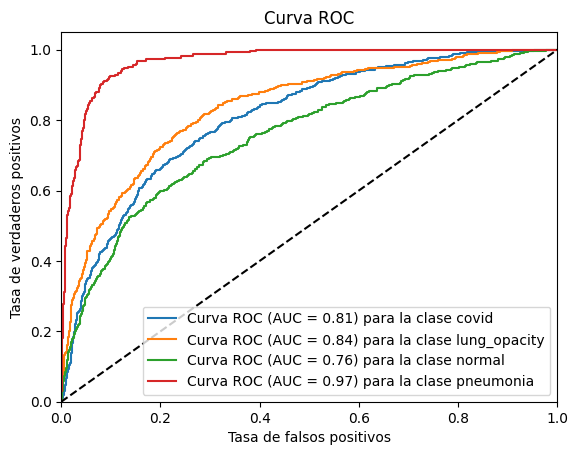

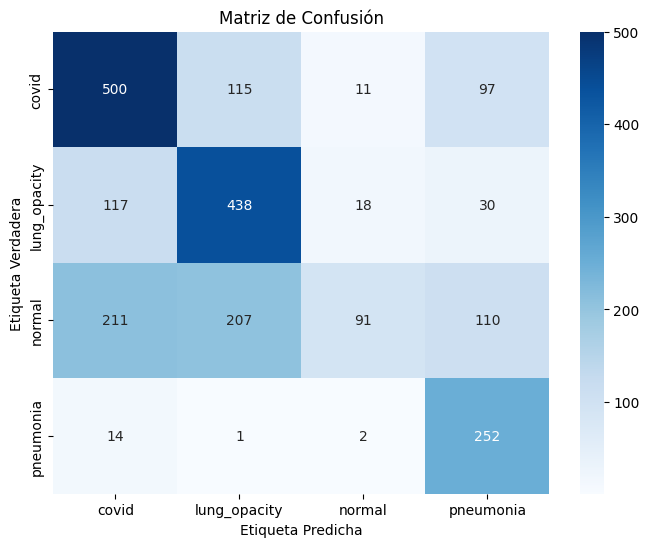

In [ ]:
######################################## Primera Arquitectura ########################################
# Crear el modelo MLP
model = tf.keras.Sequential([
    layers.Flatten(input_shape=(64, 64, 3)),  # Aplanar la imagen en un vector 1D
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')  # 4 clases de etiquetas
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Predecir las etiquetas para los datos de prueba
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calcular las métricas para cada clase
report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)

# Imprimir el informe de clasificación
print(report)

# Obtener las probabilidades de predicción para cada clase
y_pred_proba = model.predict(X_test)

fpr = dict()  # Tasa de falsos positivos
tpr = dict()  # Tasa de verdaderos positivos
roc_auc = dict()  # Área bajo la curva (AUC)

# Calcular la curva ROC y el AUC para cada clase
for i in range(4):  # Suponiendo que tienes 4 clases
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar la curva ROC
plt.figure()
for i in range(4):  # Suponiendo que tienes 4 clases
    plt.plot(fpr[i], tpr[i], label='Curva ROC (AUC = %0.2f) para la clase %s' % (roc_auc[i], label_encoder.classes_[i]))
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred_classes)

# Obtener los nombres de las etiquetas originales
etiquetas_originales = label_encoder.inverse_transform(np.unique(y_test))

# Crear un mapa de calor de la matriz de confusión con etiquetas originales
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=etiquetas_originales, yticklabels=etiquetas_originales)
plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.show()



Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


277/277 [==============================] - 19s 52ms/step - loss: 1.3154 - accuracy: 0.3768 - val_loss: 1.1044 - val_accuracy: 0.4946
Epoch 2/10
277/277 [==============================] - 8s 29ms/step - loss: 1.1015 - accuracy: 0.4911 - val_loss: 1.0317 - val_accuracy: 0.5217
Epoch 3/10
277/277 [==============================] - 9s 34ms/step - loss: 1.0189 - accuracy: 0.5413 - val_loss: 1.0709 - val_accuracy: 0.4860
Epoch 4/10
277/277 [==============================] - 8s 28ms/step - loss: 0.9800 - accuracy: 0.5749 - val_loss: 0.9890 - val_accuracy: 0.5872
Epoch 5/10
277/277 [==============================] - 9s 34ms/step - loss: 0.9041 - accuracy: 0.6176 - val_loss: 0.9855 - val_accuracy: 0.5885
Epoch 6/10
277/277 [==============================] - 10s 35ms/step - loss: 0.8379 - accuracy: 0.6531 - val_loss: 1.0674 - val_accuracy: 0.5117
Epoch 7/10
277/277 [==============================] - 10s 38ms/step - loss: 0.8445 - accuracy: 0.6513 - val_loss: 0.9356 - val_accuracy: 0.6066
Epoch 8

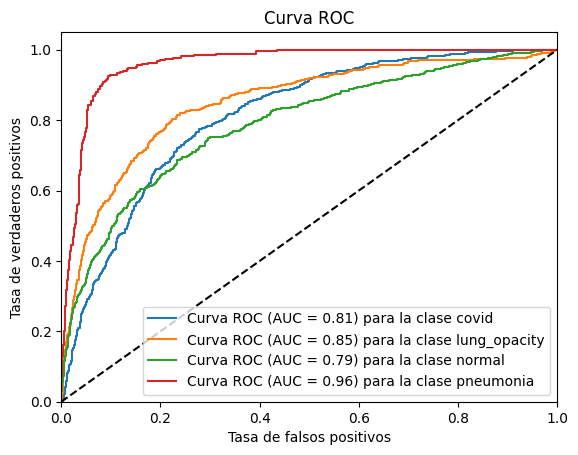

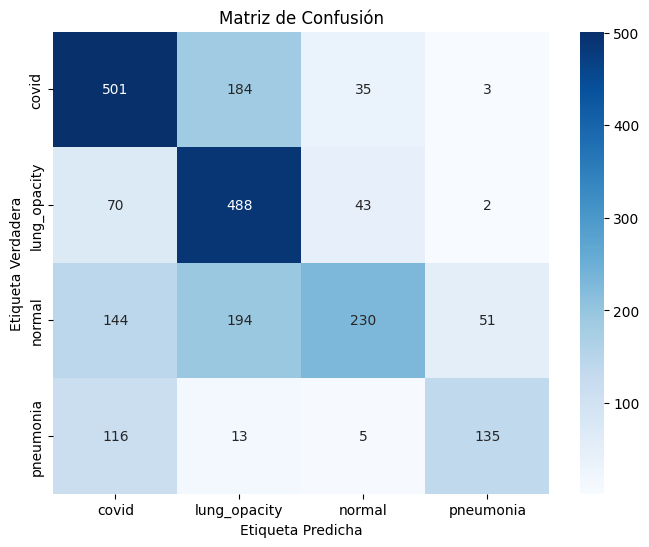

In [ ]:
######################################## Segunda Arquitectura ########################################
# Crear el modelo MLP
model = tf.keras.Sequential([
    layers.Flatten(input_shape=(64, 64, 3)),  # Aplanar la imagen en un vector 1D
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation="relu"),
    layers.Dense(4, activation='softmax')  # 4 clases de etiquetas
])
# Compilar el modelo
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Predecir las etiquetas para los datos de prueba
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calcular las métricas para cada clase
report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)

# Imprimir el informe de clasificación
print(report)

# Obtener las probabilidades de predicción para cada clase
y_pred_proba = model.predict(X_test)

fpr = dict()  # Tasa de falsos positivos
tpr = dict()  # Tasa de verdaderos positivos
roc_auc = dict()  # Área bajo la curva (AUC)

# Calcular la curva ROC y el AUC para cada clase
for i in range(4):  # Suponiendo que tienes 4 clases
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar la curva ROC
plt.figure()
for i in range(4):  # Suponiendo que tienes 4 clases
    plt.plot(fpr[i], tpr[i], label='Curva ROC (AUC = %0.2f) para la clase %s' % (roc_auc[i], label_encoder.classes_[i]))
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred_classes)

# Obtener los nombres de las etiquetas originales
etiquetas_originales = label_encoder.inverse_transform(np.unique(y_test))

# Crear un mapa de calor de la matriz de confusión con etiquetas originales
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=etiquetas_originales, yticklabels=etiquetas_originales)
plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.show()


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


277/277 [==============================] - 12s 40ms/step - loss: 1.5228 - accuracy: 0.3083 - val_loss: 1.3323 - val_accuracy: 0.3266
Epoch 2/10
277/277 [==============================] - 9s 34ms/step - loss: 1.3354 - accuracy: 0.3200 - val_loss: 1.3346 - val_accuracy: 0.3266
Epoch 3/10
277/277 [==============================] - 8s 27ms/step - loss: 1.3356 - accuracy: 0.3202 - val_loss: 1.3332 - val_accuracy: 0.3266
Epoch 4/10
277/277 [==============================] - 9s 31ms/step - loss: 1.3345 - accuracy: 0.3228 - val_loss: 1.3349 - val_accuracy: 0.3266
Epoch 5/10
277/277 [==============================] - 8s 29ms/step - loss: 1.3338 - accuracy: 0.3221 - val_loss: 1.3342 - val_accuracy: 0.3266
Epoch 6/10
277/277 [==============================] - 9s 33ms/step - loss: 1.3349 - accuracy: 0.3176 - val_loss: 1.3343 - val_accuracy: 0.3266
Epoch 7/10
277/277 [==============================] - 10s 36ms/step - loss: 1.3346 - accuracy: 0.3232 - val_loss: 1.3340 - val_accuracy: 0.3266
Epoch 8/

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       covid       0.33      1.00      0.49       723
lung_opacity       0.00      0.00      0.00       603
      normal       0.00      0.00      0.00       619
   pneumonia       0.00      0.00      0.00       269

    accuracy                           0.33      2214
   macro avg       0.08      0.25      0.12      2214
weighted avg       0.11      0.33      0.16      2214

70/70 [==============================] - 1s 9ms/step


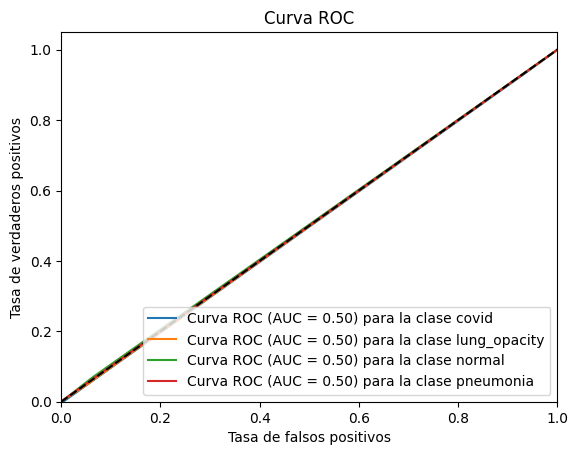

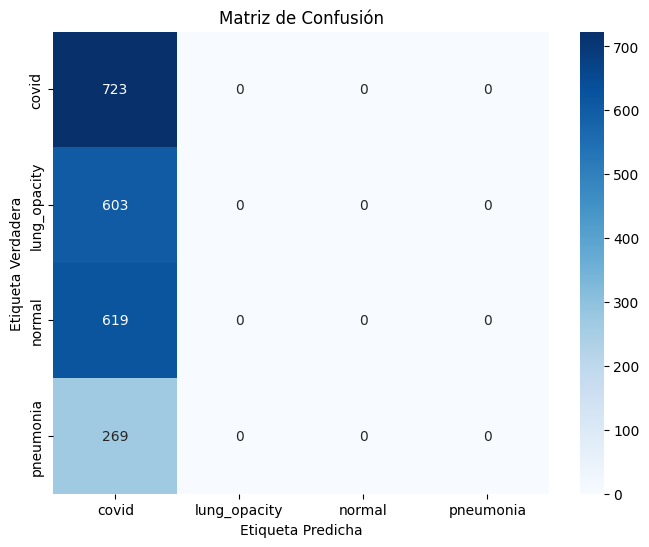

In [ ]:
######################################## Tercera Arquitectura ########################################

# Crear el modelo MLP
model = tf.keras.Sequential([
    layers.Flatten(input_shape=(64, 64, 3)),  # Aplanar la imagen en un vector 1D
    layers.Dense(128, activation="tanh"),
    layers.Dense(32, activation="tanh"),
    layers.Dense(4, activation='softmax')  # 4 clases de etiquetas
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Predecir las etiquetas para los datos de prueba
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calcular las métricas para cada clase
report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)

# Imprimir el informe de clasificación
print(report)

# Obtener las probabilidades de predicción para cada clase
y_pred_proba = model.predict(X_test)

fpr = dict()  # Tasa de falsos positivos
tpr = dict()  # Tasa de verdaderos positivos
roc_auc = dict()  # Área bajo la curva (AUC)

# Calcular la curva ROC y el AUC para cada clase
for i in range(4):  # Suponiendo que tienes 4 clases
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar la curva ROC
plt.figure()
for i in range(4):  # Suponiendo que tienes 4 clases
    plt.plot(fpr[i], tpr[i], label='Curva ROC (AUC = %0.2f) para la clase %s' % (roc_auc[i], label_encoder.classes_[i]))
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred_classes)

# Obtener los nombres de las etiquetas originales
etiquetas_originales = label_encoder.inverse_transform(np.unique(y_test))

# Crear un mapa de calor de la matriz de confusión con etiquetas originales
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=etiquetas_originales, yticklabels=etiquetas_originales)
plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.show()


# Modelo MLP - Sin feature extractor



In [ ]:
############################### Cargar los datos de prueba #######################

# Leer el dataset desde un archivo CSV o cargarlo directamente en un DataFrame
df = pd.read_csv('/content/drive/MyDrive/CE/Introduccion a patrones/Proyecto_2/DataSetPatrones/MetadataNormalizada.csv')

# Dividir los datos en características (X) y etiquetas (y)
X = df['file_paths']
y = df['labels']

# Codificar las etiquetas como valores numéricos
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# Preprocesar los datos de las imágenes en paralelo
#n_jobs=-1 son la cantidad de nucleos disponibles en su compu 
def preprocess_image_parallel(file_paths):
    return Parallel(n_jobs=2)(delayed(preprocess_image)(file_path) for file_path in file_paths)

# Preprocesar los datos de las imágenes
def preprocess_image(file_path):
    img = cv2.imread(file_path)
    img = cv2.resize(img, (64, 64))  # Redimensizonar las imágenes a 64x64
    img = img / 255.0  # Normalizar los valores de píxeles entre 0 y 1
    return img
  
#/content/drive/MyDrive/CE/Introduccion a patrones/Proyecto_2/DataSetPatrones/X_Data/X_test.npy
#/content/drive/MyDrive/CE/Introduccion a patrones/Proyecto_2/DataSetPatrones/X_Data/X_train.npy
#X_train = np.array(preprocess_image_parallel(X_train))
#X_test = np.array(preprocess_image_parallel(X_test))

X_train = np.load('/content/drive/MyDrive/CE/Introduccion a patrones/Proyecto_2/DataSetPatrones/X_Data/X_train.npy')
X_test = np.load('/content/drive/MyDrive/CE/Introduccion a patrones/Proyecto_2/DataSetPatrones/X_Data/X_test.npy')

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


277/277 [==============================] - 7s 23ms/step - loss: 1.3241 - accuracy: 0.3741 - val_loss: 1.1533 - val_accuracy: 0.4503
Epoch 2/10
277/277 [==============================] - 5s 17ms/step - loss: 1.1254 - accuracy: 0.4556 - val_loss: 1.1202 - val_accuracy: 0.4350
Epoch 3/10
277/277 [==============================] - 5s 17ms/step - loss: 1.0555 - accuracy: 0.4999 - val_loss: 1.1690 - val_accuracy: 0.4155
Epoch 4/10
277/277 [==============================] - 8s 29ms/step - loss: 0.9912 - accuracy: 0.5434 - val_loss: 1.0282 - val_accuracy: 0.5108
Epoch 5/10
277/277 [==============================] - 5s 20ms/step - loss: 0.9400 - accuracy: 0.5781 - val_loss: 1.0591 - val_accuracy: 0.4914
Epoch 6/10
277/277 [==============================] - 5s 19ms/step - loss: 0.8780 - accuracy: 0.6196 - val_loss: 0.9167 - val_accuracy: 0.6138
Epoch 7/10
277/277 [==============================] - 4s 16ms/step - loss: 0.8849 - accuracy: 0.6146 - val_loss: 0.9418 - val_accuracy: 0.5790
Epoch 8/10

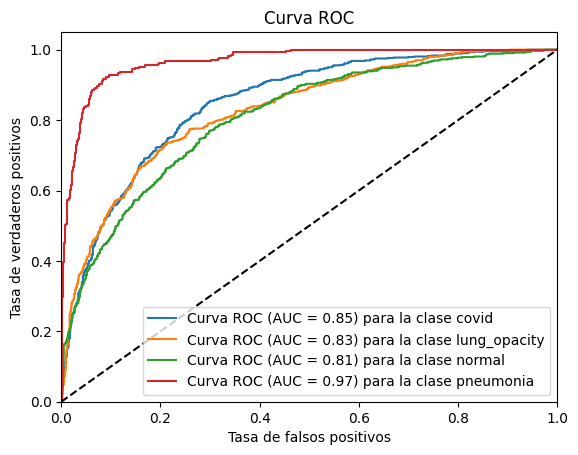

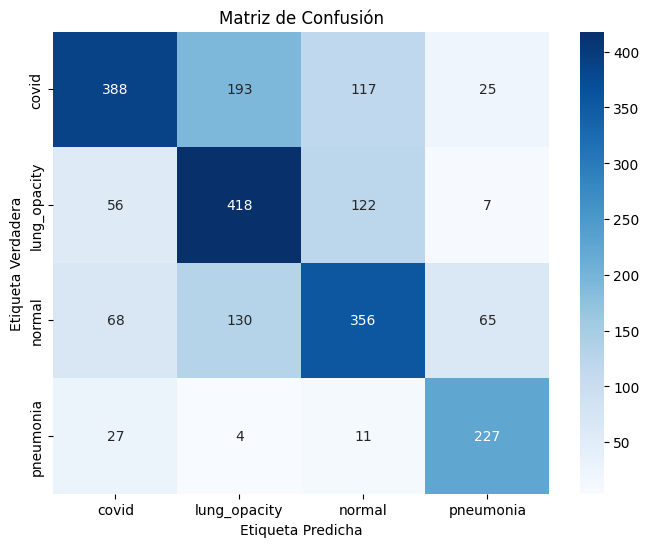

In [ ]:
############################################ Arquitectura ##################################

# Crear el modelo MLP
model = tf.keras.Sequential([
    layers.Flatten(input_shape=(64, 64, 3)),  # Aplanar la imagen en un vector 1D
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')  # 4 clases de etiquetas
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Predecir las etiquetas para los datos de prueba
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calcular las métricas para cada clase
report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)

# Imprimir el informe de clasificación
print(report)

# Obtener las probabilidades de predicción para cada clase
y_pred_proba = model.predict(X_test)

fpr = dict()  # Tasa de falsos positivos
tpr = dict()  # Tasa de verdaderos positivos
roc_auc = dict()  # Área bajo la curva (AUC)

# Calcular la curva ROC y el AUC para cada clase
for i in range(4):  # Suponiendo que tienes 4 clases
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar la curva ROC
plt.figure()
for i in range(4):  # Suponiendo que tienes 4 clases
    plt.plot(fpr[i], tpr[i], label='Curva ROC (AUC = %0.2f) para la clase %s' % (roc_auc[i], label_encoder.classes_[i]))
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred_classes)

# Obtener los nombres de las etiquetas originales
etiquetas_originales = label_encoder.inverse_transform(np.unique(y_test))

# Crear un mapa de calor de la matriz de confusión con etiquetas originales
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=etiquetas_originales, yticklabels=etiquetas_originales)
plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.show()



#Visualización de Mapas de Calor

70/70 [==============================] - 1s 8ms/step


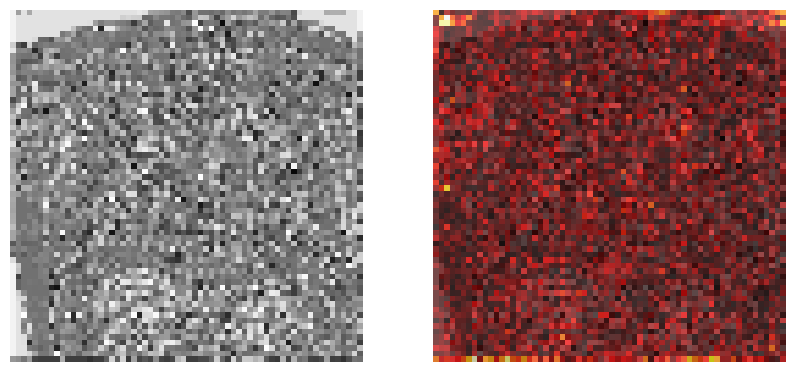

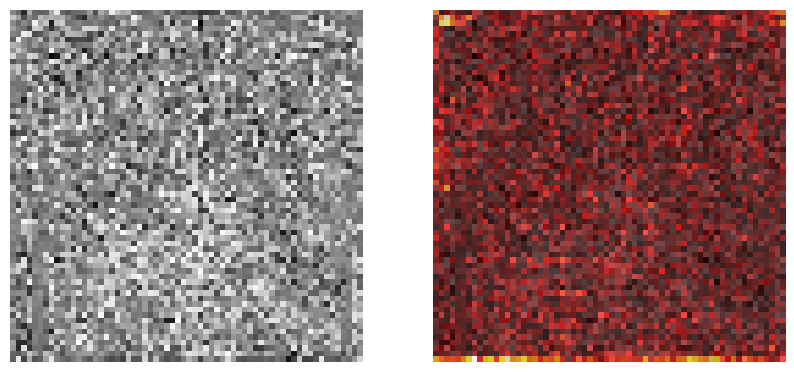

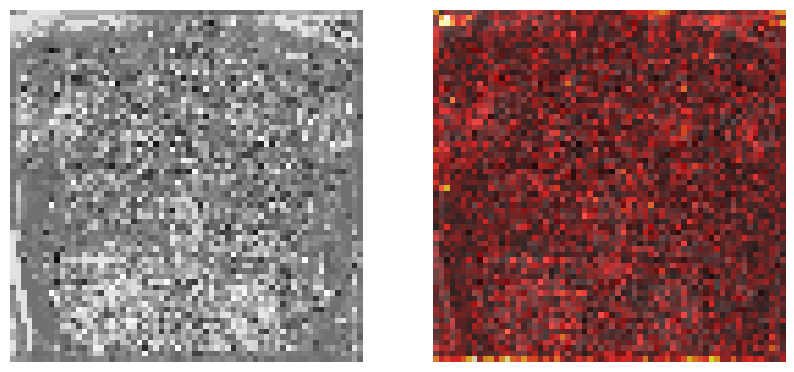

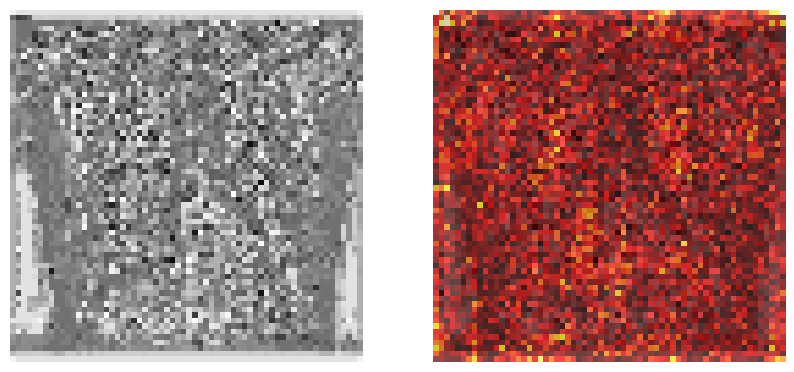

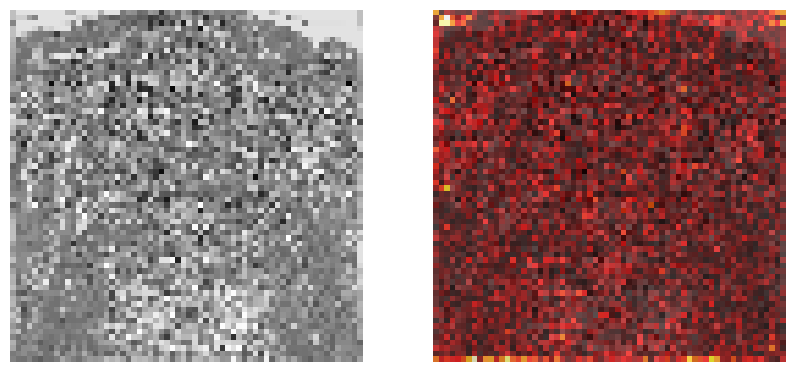

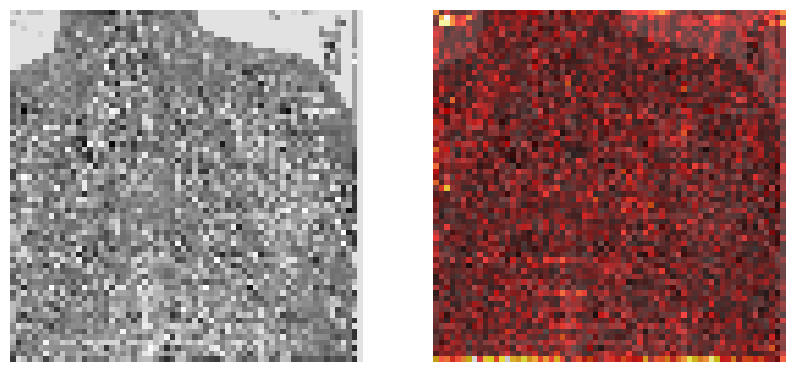

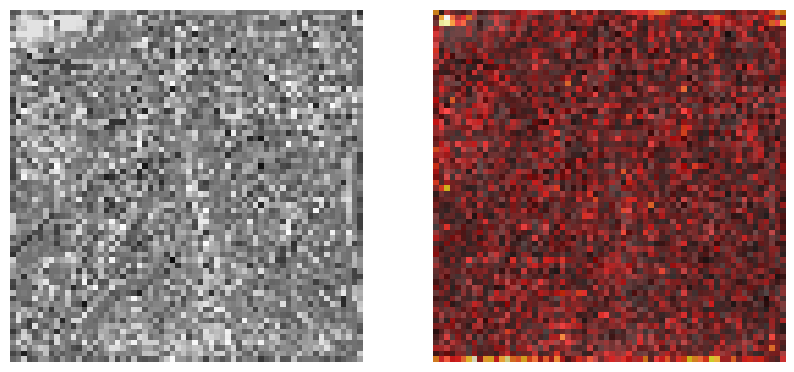

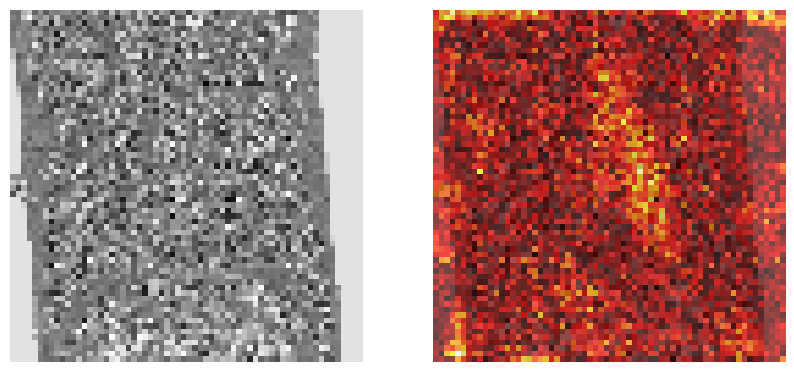

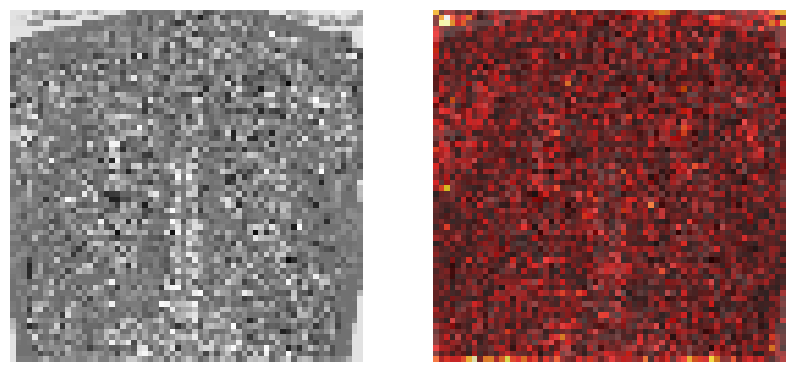

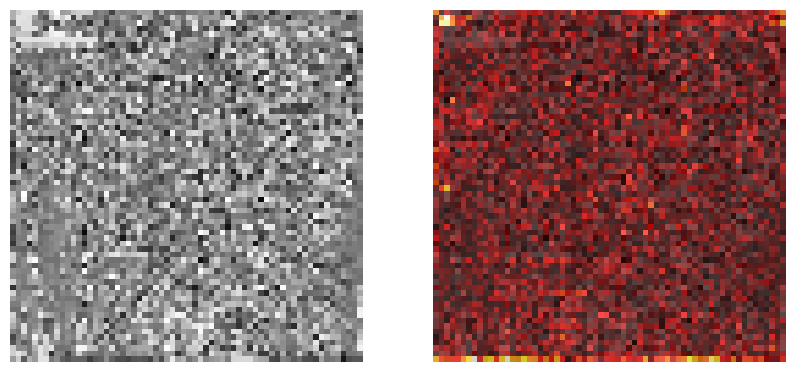

In [ ]:
# Obtener predicciones del modelo
predictions = model.predict(X_test)

# Calcular Saliency Maps
def compute_saliency_maps(images, target_class_index):
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        tape.watch(images)
        predictions = model(images)
        target_class_predictions = predictions[:, target_class_index]
    gradients = tape.gradient(target_class_predictions, images)
    saliency_maps = tf.reduce_max(tf.abs(gradients), axis=-1)
    return saliency_maps

target_class_index = 0  # Índice de la clase objetivo
saliency_maps = compute_saliency_maps(X_test, target_class_index)

# Visualizar Saliency Maps superpuestas en imágenes (solo 10 imágenes)
def visualize_saliency_maps(images, saliency_maps, num_images=10):
    for i in range(num_images):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        ax1.imshow(images[i])
        ax1.axis('off')
        ax2.imshow(images[i])
        ax2.imshow(saliency_maps[i], cmap='hot', alpha=0.7)
        ax2.axis('off')
        plt.show()

visualize_saliency_maps(X_test, saliency_maps, num_images=10)